# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('../data/kc_house_data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to stephenmoore56@msn.com and will expire on November 08, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1516761524.log


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [5]:
model_all = graphlab.linear_regression.create(sales, 
                                              target='price',
                                              features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0.,
                                              l1_penalty=1e10,
                                              verbose=False)

Find what features had non-zero weight.

In [6]:
print model_all.get("coefficients").print_rows(num_rows=20)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen?

bathrooms, sqft_living, sqft_living_sqrt, grade, sqft_above

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [7]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`


6.25766285142e+14	10.0
6.25766285362e+14	31.6227766017
6.25766286058e+14	100.0
6.25766288257e+14	316.227766017
6.25766295212e+14	1000.0
6.25766317206e+14	3162.27766017
6.25766386761e+14	10000.0
6.25766606749e+14	31622.7766017
6.25767302792e+14	100000.0
6.25769507644e+14	316227.766017
6.25776517727e+14	1000000.0
6.25799062845e+14	3162277.66017
6.25883719085e+14	10000000.0
Minimum RSS: 6.25766285142e+14


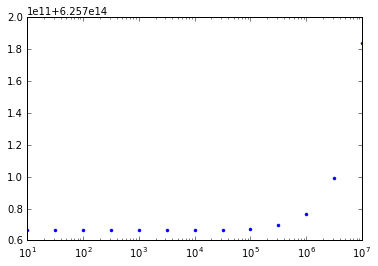

In [8]:
import numpy as np
l1_penalties = np.logspace(1, 7, num=13)
l1_errors = []
for l1_penalty in l1_penalties:
    model_train = graphlab.linear_regression.create(training, 
                                                    target='price',
                                                    features=all_features,
                                                    validation_set=None, 
                                                    l2_penalty=0.,
                                                    l1_penalty=l1_penalty,
                                                    verbose=False)
    validation_predicted = model_train.predict(validation)
    RSS = ((validation_predicted - validation['price'])**2).sum()
    l1_errors.append(RSS)
    print str(RSS) + "\t" + str(l1_penalty)
    
import matplotlib.pyplot as plt
%matplotlib inline    
plt.plot(l1_penalties, l1_errors, '.');
plt.xscale('log')
print "Minimum RSS: " + str(min(l1_errors))

 Best values:  6.25766285142e+14			10.0

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

10.0

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [9]:
model_best = graphlab.linear_regression.create(training, 
                                                target='price',
                                                features=all_features,
                                                validation_set=None, 
                                                l2_penalty=0.,
                                                l1_penalty=10.,
                                                verbose=False)
print model_best.get("coefficients").print_rows(num_rows=16)
print 'Number of nonzeros = ' + str(model_best.coefficients['value'].nnz())

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [10]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [11]:
l1_penalty_values = np.logspace(8, 10, num=20)
print min(l1_penalty_values)
print max(l1_penalty_values)

100000000.0
10000000000.0


Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

[  1.00000000e+08   1.27427499e+08   1.62377674e+08   2.06913808e+08
   2.63665090e+08   3.35981829e+08   4.28133240e+08   5.45559478e+08
   6.95192796e+08   8.85866790e+08   1.12883789e+09   1.43844989e+09
   1.83298071e+09   2.33572147e+09   2.97635144e+09   3.79269019e+09
   4.83293024e+09   6.15848211e+09   7.84759970e+09   1.00000000e+10]
2976351441.63
3792690190.73


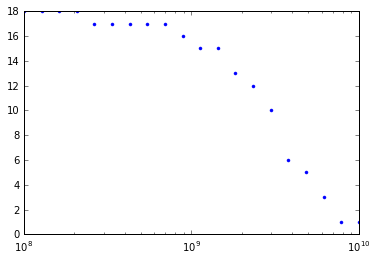

In [12]:
number_non_zeros = []
l1_penalty_min = min(l1_penalty_values)
l1_penalty_max = max(l1_penalty_values)
for l1_penalty in l1_penalty_values:
    # fit model with l1 value
    model_train = graphlab.linear_regression.create(training, 
                                                    target='price',
                                                    features=all_features,
                                                    validation_set=None, 
                                                    l2_penalty=0.,
                                                    l1_penalty=l1_penalty,
                                                    verbose=False)
    # count non-zero weights
    num_non_zero = model_train['coefficients']['value'].nnz()
    number_non_zeros.append(num_non_zero)
    
    # set values of l1_penalty_min and max
    if num_non_zero > max_nonzeros and l1_penalty > l1_penalty_min:
        l1_penalty_min = l1_penalty
    if num_non_zero < max_nonzeros and l1_penalty < l1_penalty_max:
        l1_penalty_max = l1_penalty
        
    
import matplotlib.pyplot as plt
%matplotlib inline    
plt.plot(l1_penalty_values, number_non_zeros, '.');
plt.xscale('log')
print l1_penalty_values
print l1_penalty_min
print l1_penalty_max

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [13]:
l1_penalty_min = l1_penalty_min
l1_penalty_max = l1_penalty_max
print l1_penalty_min
print l1_penalty_max

2976351441.63
3792690190.73


***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [14]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [15]:
for l1_penalty in l1_penalty_values:
    # fit model with l1 value
    model_train = graphlab.linear_regression.create(training, 
                                                    target='price',
                                                    features=all_features,
                                                    validation_set=None, 
                                                    l2_penalty=0.,
                                                    l1_penalty=l1_penalty,
                                                    verbose=False)
    validation_predicted = model_train.predict(validation)
    RSS = ((validation_predicted - validation['price'])**2).sum()
    num_non_zero = model_train['coefficients']['value'].nnz()
    print str(RSS) + "\t" + str(num_non_zero) + "\t" + str(l1_penalty)

9.66925692362e+14	10	2976351441.63
9.74019450085e+14	10	3019316638.95
9.81188367942e+14	10	3062281836.27
9.89328342459e+14	10	3105247033.59
9.98783211266e+14	10	3148212230.92
1.00847716702e+15	10	3191177428.24
1.01829878055e+15	10	3234142625.56
1.02824799221e+15	10	3277107822.88
1.03461690923e+15	8	3320073020.2
1.03855473594e+15	8	3363038217.52
1.04323723787e+15	8	3406003414.84
1.04693748875e+15	7	3448968612.16
1.05114762561e+15	7	3491933809.48
1.05599273534e+15	7	3534899006.81
1.06079953176e+15	7	3577864204.13
1.0657076895e+15	6	3620829401.45
1.06946433543e+15	6	3663794598.77
1.07350454959e+15	6	3706759796.09
1.07763277558e+15	6	3749724993.41
1.08186759232e+15	6	3792690190.73


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [16]:
best_l1 = 3448968612.16
model_best2 = graphlab.linear_regression.create(training,
                                                target='price',
                                                features=all_features,
                                                validation_set=None, 
                                                l2_penalty=0.,
                                                l1_penalty=best_l1,
                                                verbose=False)
print model_best2.get("coefficients").print_rows(num_rows=20)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 222253.192544 |  None  |
|     bedrooms     |  None | 661.722717782 |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 15873.9572593 |  None  |
|   sqft_living    |  None | 32.4102214513 |  None  |
| sqft_living_sqrt |  None | 690.114773313 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 2899.42026975 |  None  |
|    sqft_above    |  None | 30.0115753022 |  None  |
|  sqft_basement   |  None |